# About this notebook

This notebook is based off of the [Signals](https://github.com/makeabilitylab/signals/tree/master/Projects/GestureRecognizer) repository by Jon Froehlich. Much of the data and code used in this notebook is originally from Jon's work, but additional novel expansions are added. 

This notebook uses 3d accelerometer data to classify gestures made by a user. The users pre-recorded the different classes of gestures ahead of time while holding the accelerometer device. This accelerometer data is then preprocessed and used for feature engineering, ultimately being used for supervised machine learning using classical machine learning algorithms. 

# Imports

In [85]:
import itertools
import math
import os
import random

from joblib import Memory
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
from pprint import pprint
from scipy import signal
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, accuracy_score,
                            confusion_matrix, silhouette_score)
from sklearn.model_selection import (LeaveOneGroupOut, StratifiedKFold,
                                     cross_val_predict, cross_val_score,
                                     cross_validate, train_test_split,
                                    GridSearchCV)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

import gesturerec.data as grdata
import gesturerec.utility as grutils
import gesturerec.vis as grvis
from gesturerec.data import GestureSet, SensorData

In [86]:
%matplotlib inline

# Load the data 

This notebook runs on the following unified datasets:
 - All uploaded gestures from the Winter 2024 UbiComp class
 - My personal recorded gestures
    1. Standard set of 5 trials per gesture
    2. Medium speed set of 25 trials per gesture
    3. Fast speed set of 25 trials per gesture
    4. Slow speed set of 25 trials per gesture
 - The original Signals repository gestures
 - The Signals repository gestures recorded on the ADXL335GestureLogs

In [87]:
%%capture 
# %%capture hides the cell output to keep things tidy
root_gesture_log_path = './GestureLogs'

gesture_log_paths = grutils.get_immediate_subdirectories(root_gesture_log_path)
map_gesture_sets = dict()

for gesture_log_path in gesture_log_paths:
    path_to_gesture_log = os.path.join(root_gesture_log_path, gesture_log_path)
    gesture_set = GestureSet(path_to_gesture_log)
    gesture_set.load()
    map_gesture_sets[gesture_set.name] = gesture_set

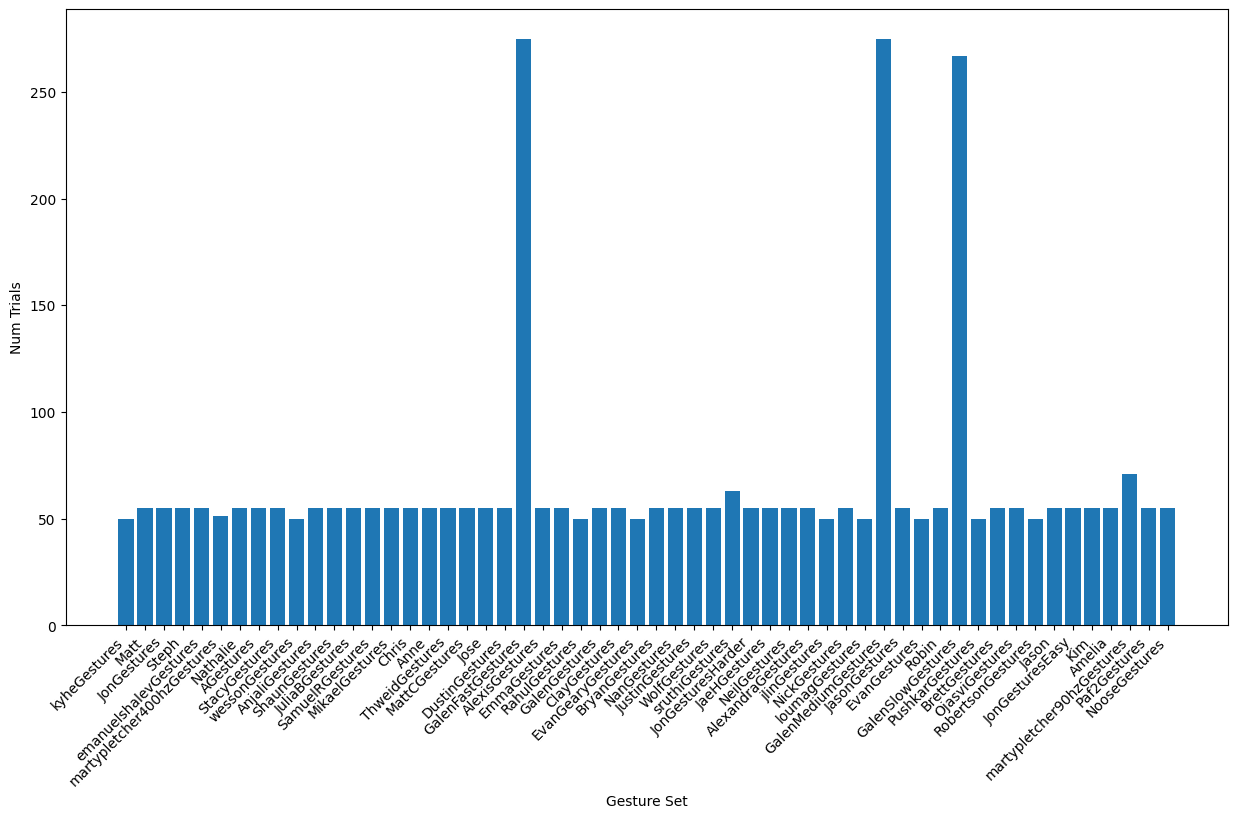

In [88]:
names = []
n_trials = []
for gesture_set_name, gesture_set in map_gesture_sets.items():
    names.append(gesture_set_name)
    n_trials.append(len(gesture_set.get_all_trials()))

plt.figure(figsize=(15, 8))
plt.bar(names, n_trials)
plt.xlabel('Gesture Set')
plt.ylabel('Num Trials')
plt.xticks(rotation=45, ha='right')
plt.show()

In [89]:
list_of_feature_vectors = []
all_feature_names = []
for gesture_set in map_gesture_sets.values():
    gesture_names = gesture_set.get_gesture_names_sorted()
    
    for gesture_name in gesture_names:
        gesture_trials = gesture_set.map_gestures_to_trials[gesture_name]
        
        for trial in gesture_trials:
            features, feature_names = [], []

            features.append(gesture_set.get_base_path())
            feature_names.append("gesturer")

            features.append(gesture_name)
            feature_names.append("gesture")

            features.append(trial.trial_num)
            feature_names.append("trial_num")
            
            features.append(trial.accel.x)
            feature_names.append("x")

            features.append(trial.accel.y)
            feature_names.append("y")

            features.append(trial.accel.z)
            feature_names.append("z")

            features.append(trial.accel.mag)
            feature_names.append("mag")

            features.append(trial.accel.sampling_rate)
            feature_names.append("sampling_rate")
            
            list_of_feature_vectors.append(features)
            all_feature_names.append(feature_names)

all_feature_names = all_feature_names[0] #not elegant but didnt want to deal with first-pass logic
df = pd.DataFrame(list_of_feature_vectors, columns=all_feature_names)
df.shape

(3707, 8)

In [90]:
df.sample(5, random_state=0)

,gesturer,gesture,trial_num,x,y,z,mag,sampling_rate
1032,Jose,At Rest,1,"[404.0, 404.0, 405.0, 405.0, 405.0, 404.0, 404.0, 404.0, 404.0, 403.0, 403.0, 404.0, 404.0, 404.0, 404.0, 404.0, 405.0, 405.0, 404.0, 404.0, 404.0, 405.0, 405.0, 405.0, 405.0, 405.0, 404.0, 404.0, 404.0, 404.0, 404.0, 404.0, 404.0, 404.0, 404.0, 404.0, 404.0, 404.0, 404.0, 404.0, 404.0, 404.0, 404.0, 404.0, 405.0, 405.0, 405.0, 404.0, 404.0, 404.0, 404.0, 404.0, 403.0, 404.0, 403.0, 404.0, 404.0, 404.0, 404.0, 405.0, 405.0, 405.0, 405.0, 405.0, 404.0, 404.0, 404.0, 405.0, 405.0, 405.0, 404.0, 404.0, 404.0, 404.0, 404.0, 404.0, 404.0, 404.0, 405.0, 404.0, 404.0, 404.0, 404.0, 404.0, 404.0, 403.0, 403.0, 404.0, 405.0, 405.0, 404.0, 405.0, 405.0, 405.0, 405.0, 405.0, 405.0, 405.0, 404.0, 404.0, ...]","[318.0, 317.0, 317.0, 317.0, 318.0, 317.0, 317.0, 317.0, 316.0, 316.0, 315.0, 316.0, 317.0, 317.0, 318.0, 317.0, 317.0, 316.0, 316.0, 317.0, 317.0, 318.0, 318.0, 318.0, 317.0, 317.0, 317.0, 316.0, 317.0, 317.0, 317.0, 316.0, 316.0, 316.0, 316.0, 317.0, 317.0, 317.0, 317.0, 316.0, 316.0, 316.0, 317.0, 317.0, 316.0, 316.0, 317.0, 317.0, 318.0, 318.0, 317.0, 316.0, 315.0, 315.0, 315.0, 316.0, 316.0, 317.0, 317.0, 318.0, 318.0, 317.0, 316.0, 316.0, 316.0, 317.0, 317.0, 316.0, 316.0, 316.0, 316.0, 316.0, 317.0, 317.0, 317.0, 316.0, 316.0, 317.0, 317.0, 317.0, 316.0, 316.0, 317.0, 317.0, 317.0, 316.0, 316.0, 316.0, 316.0, 316.0, 316.0, 317.0, 317.0, 317.0, 317.0, 317.0, 317.0, 316.0, 316.0, 316.0, ...]","[351.0, 351.0, 352.0, 352.0, 353.0, 352.0, 352.0, 352.0, 352.0, 352.0, 351.0, 351.0, 353.0, 352.0, 352.0, 352.0, 352.0, 352.0, 352.0, 352.0, 351.0, 352.0, 352.0, 352.0, 352.0, 351.0, 352.0, 351.0, 351.0, 352.0, 352.0, 352.0, 352.0, 352.0, 351.0, 351.0, 352.0, 352.0, 352.0, 352.0, 352.0, 352.0, 352.0, 352.0, 352.0, 352.0, 352.0, 352.0, 352.0, 352.0, 351.0, 351.0, 351.0, 351.0, 352.0, 352.0, 352.0, 351.0, 351.0, 352.0, 352.0, 351.0, 351.0, 352.0, 352.0, 351.0, 352.0, 352.0, 352.0, 352.0, 351.0, 351.0, 351.0, 352.0, 352.0, 352.0, 352.0, 352.0, 352.0, 352.0, 352.0, 351.0, 352.0, 352.0, 352.0, 351.0, 351.0, 352.0, 352.0, 351.0, 351.0, 352.0, 352.0, 352.0, 352.0, 352.0, 352.0, 352.0, 351.0, 351.0, ...]","[622.5279110208634, 622.017684636056, 623.2318990552393, 623.2318990552393, 624.3060147075311, 622.5825246503471, 622.5825246503471, 622.5825246503471, 622.0739505878702, 621.4249753590533, 620.3507072616263, 621.5086483710423, 623.1484574320954, 622.5825246503471, 623.0922885094952, 622.5825246503471, 623.2318990552393, 622.7238553323616, 622.0739505878702, 622.5825246503471, 622.017684636056, 623.7411322014927, 623.7411322014927, 623.7411322014927, 623.2318990552393, 622.6676481077204, 622.5825246503471, 621.5086483710423, 622.017684636056, 622.5825246503471, 622.5825246503471, 622.0739505878702, 622.0739505878702, 622.0739505878702, 621.5086483710423, 622.017684636056, 622.5825246503471, 622.5825246503471, 622.5825246503471, 622.0739505878702, 622.0739505878702, 622.0739505878702, 622.5825246503471, 622.5825246503471, 622.7238553323616, 622.7238553323616, 623.2318990552393, 622.5825246503471, 623.0922885094952, 623.0922885094952, 622.017684636056, 621.5086483710423, 620.3507072616263, 621.0008051524571, 620.9170637049685, 622.0739505878702, 622.0739505878702, 622.017684636056, 622.017684636056, 623.7411322014927, 623.7411322014927, 622.6676481077204, 622.1591436280592, 622.7238553323616, 622.0739505878702, 622.017684636056, 622.5825246503471, 622.7238553323616, 622.7238553323616, 622.7238553323616, 621.5086483710423, 621.5086483710423, 622.017684636056, 622.5825246503471, 622.5825246503471, 622.0739505878702, 622.0739505878702, 622.5825246503471, 623.2318990552393, 622.5825246503471, 622.0739505878702, 621.5086483710423, 622.5825246503471, 622.5825246503471, 622.5825246503471, 620.8590822400845, 620.8590822400845, 622.0739505878702, 622.7238553323616, 622.1591436280592, 621.5086483710423, 623.2318990552393, 623.2318990552393, 623.2318990552393, 623.2318990552393, 623.23

Now that we have the raw sensor data into Pandas, let's do some preprocessing. 

I know firsthand that there are at least a handful of trials with bunk data. This is because my microprocessor came unplugged while I was violently swinging it around. We'll want to find any trials with `0.0` values for all of the sensor data and drop them from the dataframe.

In [91]:
sensor_cols = ['x', 'y', 'z', 'mag']
# Find rows where one of the arrays contains NaN or null
rows_with_nan = df[df[sensor_cols].apply(lambda x: pd.Series(x).apply(lambda arr: np.any(pd.isna(arr)))).any(axis=1)]
rows_with_all_zeros = df[df[sensor_cols].apply(lambda x: np.all(x.apply(lambda arr: np.all(arr == 0.0))), axis=1)]
df = df.drop(rows_with_all_zeros.index)
df = df.drop(rows_with_nan.index)
df.shape # we dropped 3 trials

(3704, 8)

# Preprocess the data

We'll be using z-score normalization for this data. More work could be done to use z-score thresholding to remove outlier trials, but things get a little tricky because you'd need to compare the z-score for a given trial sensor data stream to the average sensor data stream for that gesture. For now, we'll just normalize and leave any outliers in the dataset. 

We'll use z-score normalization again with the `sklearn.preprocessing.StandardScaler`, but doing it now on the raw data helps us to remove a few trials. 

In [92]:
# normalize sensor data using z-score
df[sensor_cols] = df[sensor_cols].map(lambda arr: sp.stats.zscore(arr))
df.sample(5, random_state=0)

,gesturer,gesture,trial_num,x,y,z,mag,sampling_rate
1032,Jose,At Rest,1,"[-0.20787190788675103, -0.20787190788675103, 1.3802694683683518, 1.3802694683683518, 1.3802694683683518, -0.20787190788675103, -0.20787190788675103, -0.20787190788675103, -0.20787190788675103, -1.796013284141854, -1.796013284141854, -0.20787190788675103, -0.20787190788675103, -0.20787190788675103, -0.20787190788675103, -0.20787190788675103, 1.3802694683683518, 1.3802694683683518, -0.20787190788675103, -0.20787190788675103, -0.20787190788675103, 1.3802694683683518, 1.3802694683683518, 1.3802694683683518, 1.3802694683683518, 1.3802694683683518, -0.20787190788675103, -0.20787190788675103, -0.20787190788675103, -0.20787190788675103, -0.20787190788675103, -0.20787190788675103, -0.20787190788675103, -0.20787190788675103, -0.20787190788675103, -0.20787190788675103, -0.20787190788675103, -0.20787190788675103, -0.20787190788675103, -0.20787190788675103, -0.20787190788675103, -0.20787190788675103, -0.20787190788675103, -0.20787190788675103, 1.3802694683683518, 1.3802694683683518, 1.3802694683683518, -0.20787190788675103, -0.20787190788675103, -0.20787190788675103, -0.20787190788675103, -0.20787190788675103, -1.796013284141854, -0.20787190788675103, -1.796013284141854, -0.20787190788675103, -0.20787190788675103, -0.20787190788675103, -0.20787190788675103, 1.3802694683683518, 1.3802694683683518, 1.3802694683683518, 1.3802694683683518, 1.3802694683683518, -0.20787190788675103, -0.20787190788675103, -0.20787190788675103, 1.3802694683683518, 1.3802694683683518, 1.3802694683683518, -0.20787190788675103, -0.20787190788675103, -0.20787190788675103, -0.20787190788675103, -0.20787190788675103, -0.20787190788675103, -0.20787190788675103, -0.20787190788675103, 1.3802694683683518, -0.20787190788675103, -0.20787190788675103, -0.20787190788675103, -0.20787190788675103, -0.20787190788675103, -0.20787190788675103, -1.796013284141854, -1.796013284141854, -0.20787190788675103, 1.3802694683683518, 1.3802694683683518, -0.20787190788675103, 1.3802694683683518, 1.3802694683683518, 1.3802694683683518, 1.3802694683683518, 1.3802694683683518, 1.3802694683683518, 1.3802694683683518, -0.20787190788675103, -0.20787190788675103, ...]","[2.3377385121992194, 0.8241518822668679, 0.8241518822668679, 0.8241518822668679, 2.3377385121992194, 0.8241518822668679, 0.8241518822668679, 0.8241518822668679, -0.6894347476654834, -0.6894347476654834, -2.203021377597835, -0.6894347476654834, 0.8241518822668679, 0.8241518822668679, 2.3377385121992194, 0.8241518822668679, 0.8241518822668679, -0.6894347476654834, -0.6894347476654834, 0.8241518822668679, 0.8241518822668679, 2.3377385121992194, 2.3377385121992194, 2.3377385121992194, 0.8241518822668679, 0.8241518822668679, 0.8241518822668679, -0.6894347476654834, 0.8241518822668679, 0.8241518822668679, 0.8241518822668679, -0.6894347476654834, -0.6894347476654834, -0.6894347476654834, -0.6894347476654834, 0.8241518822668679, 0.8241518822668679, 0.8241518822668679, 0.8241518822668679, -0.6894347476654834, -0.6894347476654834, -0.6894347476654834, 0.8241518822668679, 0.8241518822668679, -0.6894347476654834, -0.6894347476654834, 0.8241518822668679, 0.8241518822668679, 2.3377385121992194, 2.3377385121992194, 0.8241518822668679, -0.6894347476654834, -2.203021377597835, -2.203021377597835, -2.203021377597835, -0.6894347476654834, -0.6894347476654834, 0.8241518822668679, 0.8241518822668679, 2.3377385121992194, 2.3377385121992194, 0.8241518822668679, -0.6894347476654834, -0.6894347476654834, -0.6894347476654834, 0.8241518822668679, 0.8241518822668679, -0.6894347476654834, -0.6894347476654834, -0.6894347476654834, -0.6894347476654834, -0.6894347476654834, 0.8241518822668679, 0.8241518822668679, 0.8241518822668679, -0.6894347476654834, -0.6894347476654834, 0.8241518822668679, 0.8241518822668679, 0.8241518822668679, -0.6894347476654834, -0.6894347476654834, 0.8241518822668679, 0.8241518822668679, 0.8241518822668679, -0.6894347476654834, -0.6894347476654834, -0.6894347476654834,

A few other rows cause an issue with the `At Rest` gesture. This is because the values for certain axis are essentially the same. We'll drop a few of these too. 

In [93]:
# find problem rows after z-score
rows_with_nan = df[df[sensor_cols].apply(lambda x: pd.Series(x).apply(lambda arr: np.any(pd.isna(arr)))).any(axis=1)]
rows_with_nan

,gesturer,gesture,trial_num,x,y,z,mag,sampling_rate
2019,JonGesturesHarder,At Rest,0,"[0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, 0.05089865985591719, ...]","[0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, -6.303716531163468, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, -6.303716531163468, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.1586365749563947, 0.158

In [94]:
df = df.drop(rows_with_nan.index)
df.shape

(3700, 8)

Lastly, let's smooth out our normalized sensor data. 

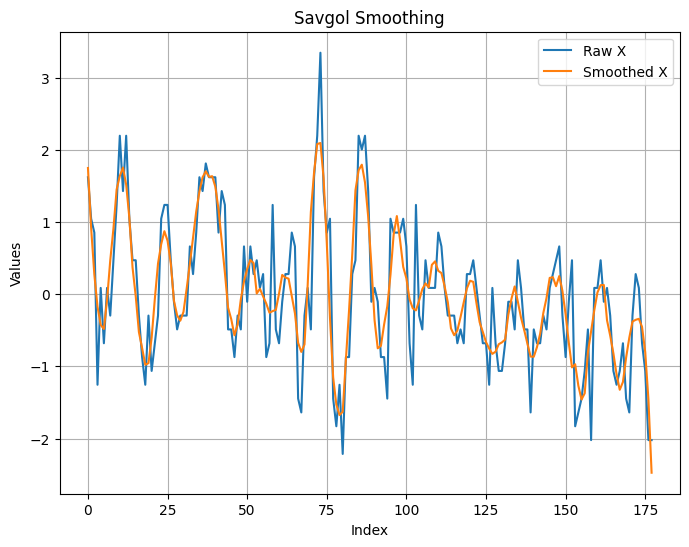

In [95]:
old_x = df['x'][0].copy()

# Smoothing function using scipy's savgol_filter
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html
def smooth_array(arr, window_length=10, polyorder=3):
    smoothed_arr = sp.signal.savgol_filter(arr, window_length, polyorder)
    return smoothed_arr

for column in sensor_cols:
    df[column] = df[column].apply(lambda arr: smooth_array(arr))


plt.figure(figsize=(8, 6))
plt.plot(old_x, label='Raw X')
plt.plot(df['x'][0], label='Smoothed X')
plt.title('Savgol Smoothing')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

# Feature Engineering

Let's use our raw sensor data to add additional features to the dataset. 

In [96]:
df['mag_max'] = df['mag'].apply(lambda arr: np.max(arr))
df['mag_min'] = df['mag'].apply(lambda arr: np.min(arr))
df['mag_std'] = df['mag'].apply(lambda arr: np.std(arr))

df['x_max'] = df['x'].apply(lambda arr: np.max(arr))
df['x_min'] = df['x'].apply(lambda arr: np.min(arr))
df['x_std'] = df['x'].apply(lambda arr: np.std(arr))

df['y_max'] = df['y'].apply(lambda arr: np.max(arr))
df['y_min'] = df['y'].apply(lambda arr: np.min(arr))
df['y_std'] = df['y'].apply(lambda arr: np.std(arr))

df['z_max'] = df['z'].apply(lambda arr: np.max(arr))
df['z_min'] = df['z'].apply(lambda arr: np.min(arr))
df['z_std'] = df['z'].apply(lambda arr: np.std(arr))

df['signal_length'] = df['mag'].apply(lambda arr: len(arr))
df.sample(5, random_state=0)

,gesturer,gesture,trial_num,x,y,z,mag,sampling_rate,mag_max,mag_min,...,x_max,x_min,x_std,y_max,y_min,y_std,z_max,z_min,z_std,signal_length
526,wessonGestures,Shake,0,"[0.9231713466944442, 0.9153875144667775, 0.9092500195255135, 0.9050616365440136, 0.9031251401956395, 0.9083727614484807, 0.9160398992707895, 0.9212039420981681, 0.9220946831098775, 0.916411980959225, 0.9094100800950282, 0.9032425442291414, 0.8922379464135921, 0.8854728248056726, 0.8839281220385311, 0.8861042361557454, 0.8889117616230321, 0.8941772812745296, 0.9009424028824493, 0.9079104781386066, 0.9128039161016687, 0.9197156153444273, 0.9414880317192491, 0.9940868522208244, 1.070803331254633, 1.1659998674807415, 1.2615910358006448, 1.3227251847308772, 1.3397958415881925, 1.2772522923229732, 1.1275063255316702, 0.8810642205578367, 0.6356256086225107, 0.3298533871472225, 0.0013278066639654668, -0.3315612772563989, -0.6440309691235254, -0.8994143098224895, -1.1200362006594258, -1.2612693894274254, -1.3811022435090377, -1.3329796784713641, -1.1629721724643405, -0.8539526926172495, -0.4288662763836188, 0.021442768244872283, 0.5050136607789663, 0.944137704349026, 1.2414760742197697, 1.3246194187810962, 1.2731706689528623, 1.0950337418136544, 0.7508130792000214, 0.35632756303954555, -0.1259692315917265, -0.5765150554764935, -0.9937877562529747, -1.3989621645539594, -1.7263827751745868, -1.9767599258836892, -2.1376796185307345, -2.280953618983789, -2.297686019760705, -2.2455269321636395, -2.0137200402682693, -1.5966164675319834, -1.1230805053829676, -0.5736511539957749, -0.025067442809573154, 0.4501710749440993, 0.8069523133430958, 0.9906253649981086, 1.0229288206759193, 0.9455696550893556, 0.8375757638215953, 0.5579732877662734, 0.20229701922989796, -0.22458215422982988, -0.5873730756571993, -0.8310978567851829, -1.0637052880708182, -1.2490470697224547, -1.4126840862153485, -1.4666133806331445, -1.605309648798172, -1.575498012912606, -1.4672109663751725, -1.3289318807092916, -1.1080281098053524, -0.8013313217103147, -0.4901921037594098, -0.14394190466340334, 0.23154489498149392, 0.5700039290257085, 0.948670335826329, 1.1867011396009768, 1.1132882949523646, 0.9344748556523661, 0.709872818269432, 0.39815856498185176, ...]","[-0.05118680636385274, -0.031790488587317256, -0.019370690420627147, -0.012791394827359907, -0.01091658477109303, -0.013957367356241396, -0.019627917525043857, -0.026240633408167402, -0.03021996685995853, -0.028230300134062834, -0.016093333106099648, -0.0015687660070618087, 0.010521385333233133, 0.01862635126077836, 0.022406718039979956, 0.02132995722361284, 0.017596406132079172, 0.012458384410501552, 0.005412623416447612, 0.0004969762112936311, -0.0033770219432447176, -0.01663171351428517, -0.05036241647917478, -0.11597460274606193, -0.22140353137469448, -0.3484261959402522, -0.4737342359449643, -0.5790695331982593, -0.6429202792166303, -0.6260139640074737, -0.5212872706938603, -0.3307591258064783, -0.0345738258130827, 0.35378571123790387, 0.812005958211658, 1.2596341558504958, 1.6065910691199736, 1.7673444366504154, 1.735503917075122, 1.4626152736575775, 0.9783596523793782, 0.3927656231825518, -0.20320393279372229, -0.7152505166639104, -1.1194103483028883, -1.4122307707451316, -1.6028291391640086, -1.6735851991134267, -1.679723906158907, -1.6221464622880617, -1.5096074010948297, -1.362863628099069, -1.181037349157, -0.9109049793509186, -0.5382989212002567, -0.03346780519191778, 0.5358636245011885, 1.0955627264565762, 1.6192430087122938, 2.016591157795556, 2.1999623544306623, 2.1067464683224464, 1.8261098285958242, 1.3196694233238895, 0.7150097053242174, 0.05851331715400694, -0.5860333667389115, -1.0985598114076969, -1.4518309905514146, -1.6685583646500668, -1.7535932093382653, -1.7608847526925724, -1.7463777414764072, -1.6465608434069894, -1.47077378817411, -1.255708370987668, -0.8733880576458681, -0.3517267019208348, 0.20723505295378095, 0.779369571946017, 1.2745391004118432, 1.699057904225499, 2.005630434920254, 2.1311667014023423, 2.050912908817

In [97]:
def extract_feature_top_mag_freq2(df, axis):
    sampling_rate = math.ceil(df['sampling_rate'])
    fft_freqs, fft_amplitudes  = compute_fft(df[axis], sampling_rate)
    top_n_freq_with_amplitudes = get_top_n_frequency_peaks(1, fft_freqs, fft_amplitudes, min_amplitude_threshold = None)

    if len(top_n_freq_with_amplitudes) <= 0:
        return 0
    
    return top_n_freq_with_amplitudes[0][0]

def compute_fft(s, sampling_rate, n = None, scale_amplitudes = True):
    '''Computes an FFT on signal s using numpy.fft.fft.
    
       Parameters:
        s (np.array): the signal
        sampling_rate (num): sampling rate
        n (integer): If n is smaller than the length of the input, the input is cropped. If n is 
            larger, the input is padded with zeros. If n is not given, the length of the input signal 
            is used (i.e., len(s))
        scale_amplitudes (boolean): If true, the spectrum amplitudes are scaled by 2/len(s)
    '''
    if n == None:
        n = len(s)
        
    fft_result = np.fft.fft(s, n)
    num_freq_bins = len(fft_result)
    fft_freqs = np.fft.fftfreq(num_freq_bins, d = 1 / sampling_rate)
    half_freq_bins = num_freq_bins // 2

    fft_freqs = fft_freqs[:half_freq_bins]
    fft_result = fft_result[:half_freq_bins]
    fft_amplitudes = np.abs(fft_result)
    
    if scale_amplitudes is True:
        fft_amplitudes = 2 * fft_amplitudes / (len(s))
    
    return fft_freqs, fft_amplitudes

def get_top_n_frequency_peaks(n, freqs, amplitudes, min_amplitude_threshold = None):
    ''' Finds the top N frequencies and returns a sorted list of tuples (freq, amplitudes) '''
    
    # Use SciPy signal.find_peaks to find the frequency peak
    fft_peaks_indices, fft_peaks_props = sp.signal.find_peaks(amplitudes, height = min_amplitude_threshold)
    
    freqs_at_peaks = freqs[fft_peaks_indices]
    amplitudes_at_peaks = amplitudes[fft_peaks_indices]
    
    if n < len(amplitudes_at_peaks):
        ind = np.argpartition(amplitudes_at_peaks, -n)[-n:] # from https://stackoverflow.com/a/23734295
        ind_sorted_by_coef = ind[np.argsort(-amplitudes_at_peaks[ind])] # reverse sort indices
    else:
        ind_sorted_by_coef = np.argsort(-amplitudes_at_peaks)

    return_list = list(zip(freqs_at_peaks[ind_sorted_by_coef], amplitudes_at_peaks[ind_sorted_by_coef]))
    return return_list

def extract_feature_num_peaks_mag(df, axis):
    mag = sp.signal.detrend(df[axis])
    
    # height is the height of the peaks and distance is the minimum horizontal distance
    # (in samples) between peaks. Feel free to play with these thresholds
    peak_indices, peak_properties = sp.signal.find_peaks(mag, height=None, distance=5)
    return len(peak_indices)

df['mag_top_freq']  = df.apply(lambda row: extract_feature_top_mag_freq2(row, 'mag'), axis=1)
df['mag_num_peaks'] = df.apply(lambda row: extract_feature_num_peaks_mag(row, 'mag'), axis=1)

df['x_top_freq']    = df.apply(lambda row: extract_feature_top_mag_freq2(row, 'x'),   axis=1)
df['x_num_peaks']   = df.apply(lambda row: extract_feature_num_peaks_mag(row, 'x'),   axis=1)

df['y_top_freq']    = df.apply(lambda row: extract_feature_top_mag_freq2(row, 'y'),   axis=1)
df['y_num_peaks']   = df.apply(lambda row: extract_feature_num_peaks_mag(row, 'y'),   axis=1)

df['z_top_freq']    = df.apply(lambda row: extract_feature_top_mag_freq2(row, 'z'),   axis=1)
df['z_num_peaks']   = df.apply(lambda row: extract_feature_num_peaks_mag(row, 'z'),   axis=1)

df.sample(5, random_state=0)

,gesturer,gesture,trial_num,x,y,z,mag,sampling_rate,mag_max,mag_min,...,z_std,signal_length,mag_top_freq,mag_num_peaks,x_top_freq,x_num_peaks,y_top_freq,y_num_peaks,z_top_freq,z_num_peaks
526,wessonGestures,Shake,0,"[0.9231713466944442, 0.9153875144667775, 0.9092500195255135, 0.9050616365440136, 0.9031251401956395, 0.9083727614484807, 0.9160398992707895, 0.9212039420981681, 0.9220946831098775, 0.916411980959225, 0.9094100800950282, 0.9032425442291414, 0.8922379464135921, 0.8854728248056726, 0.8839281220385311, 0.8861042361557454, 0.8889117616230321, 0.8941772812745296, 0.9009424028824493, 0.9079104781386066, 0.9128039161016687, 0.9197156153444273, 0.9414880317192491, 0.9940868522208244, 1.070803331254633, 1.1659998674807415, 1.2615910358006448, 1.3227251847308772, 1.3397958415881925, 1.2772522923229732, 1.1275063255316702, 0.8810642205578367, 0.6356256086225107, 0.3298533871472225, 0.0013278066639654668, -0.3315612772563989, -0.6440309691235254, -0.8994143098224895, -1.1200362006594258, -1.2612693894274254, -1.3811022435090377, -1.3329796784713641, -1.1629721724643405, -0.8539526926172495, -0.4288662763836188, 0.021442768244872283, 0.5050136607789663, 0.944137704349026, 1.2414760742197697, 1.3246194187810962, 1.2731706689528623, 1.0950337418136544, 0.7508130792000214, 0.35632756303954555, -0.1259692315917265, -0.5765150554764935, -0.9937877562529747, -1.3989621645539594, -1.7263827751745868, -1.9767599258836892, -2.1376796185307345, -2.280953618983789, -2.297686019760705, -2.2455269321636395, -2.0137200402682693, -1.5966164675319834, -1.1230805053829676, -0.5736511539957749, -0.025067442809573154, 0.4501710749440993, 0.8069523133430958, 0.9906253649981086, 1.0229288206759193, 0.9455696550893556, 0.8375757638215953, 0.5579732877662734, 0.20229701922989796, -0.22458215422982988, -0.5873730756571993, -0.8310978567851829, -1.0637052880708182, -1.2490470697224547, -1.4126840862153485, -1.4666133806331445, -1.605309648798172, -1.575498012912606, -1.4672109663751725, -1.3289318807092916, -1.1080281098053524, -0.8013313217103147, -0.4901921037594098, -0.14394190466340334, 0.23154489498149392, 0.5700039290257085, 0.948670335826329, 1.1867011396009768, 1.1132882949523646, 0.9344748556523661, 0.709872818269432, 0.39815856498185176, ...]","[-0.05118680636385274, -0.031790488587317256, -0.019370690420627147, -0.012791394827359907, -0.01091658477109303, -0.013957367356241396, -0.019627917525043857, -0.026240633408167402, -0.03021996685995853, -0.028230300134062834, -0.016093333106099648, -0.0015687660070618087, 0.010521385333233133, 0.01862635126077836, 0.022406718039979956, 0.02132995722361284, 0.017596406132079172, 0.012458384410501552, 0.005412623416447612, 0.0004969762112936311, -0.0033770219432447176, -0.01663171351428517, -0.05036241647917478, -0.11597460274606193, -0.22140353137469448, -0.3484261959402522, -0.4737342359449643, -0.5790695331982593, -0.6429202792166303, -0.6260139640074737, -0.5212872706938603, -0.3307591258064783, -0.0345738258130827, 0.35378571123790387, 0.812005958211658, 1.2596341558504958, 1.6065910691199736, 1.7673444366504154, 1.735503917075122, 1.4626152736575775, 0.9783596523793782, 0.3927656231825518, -0.20320393279372229, -0.7152505166639104, -1.1194103483028883, -1.4122307707451316, -1.6028291391640086, -1.6735851991134267, -1.679723906158907, -1.6221464622880617, -1.5096074010948297, -1.362863628099069, -1.181037349157, -0.9109049793509186, -0.5382989212002567, -0.03346780519191778, 0.5358636245011885, 1.0955627264565762, 1.6192430087122938, 2.016591157795556, 2.1999623544306623, 2.1067464683224464, 1.8261098285958242, 1.3196694233238895, 0.7150097053242174, 0.05851331715400694, -0.5860333667389115, -1.0985598114076969, -1.4518309905514146, -1.6685583646500668, -1.7535932093382653, -1.7608847526925724, -1.7463777414764072, -1.6465608434069894, -1.47077378817411, -1.255708370987668, -0.8733880576458681, -0.3517267019208348, 0.20723505295378095, 0.779369571946017, 1.2745391004118432, 1.699057904225499, 2.005

# Feature Analysis

## Pairwise correlation

We can use Pandas to calculate a pairwise correlation between features. Often, we want features that have low (near zero) correlation with one another. If multiple features are highly correlated, then they will not improve our classification performance (and will also slow down training).

The function [`df.corr()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html) computes a pairwise correlation of columns (by default, using a [Pearson correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient), which measures the linear correlation between two variables).

For more on understanding the relationship between your input features and the Pearson correlation, read this [article](https://machinelearningmastery.com/how-to-use-correlation-to-understand-the-relationship-between-variables/) from Machine Learning Mastery.

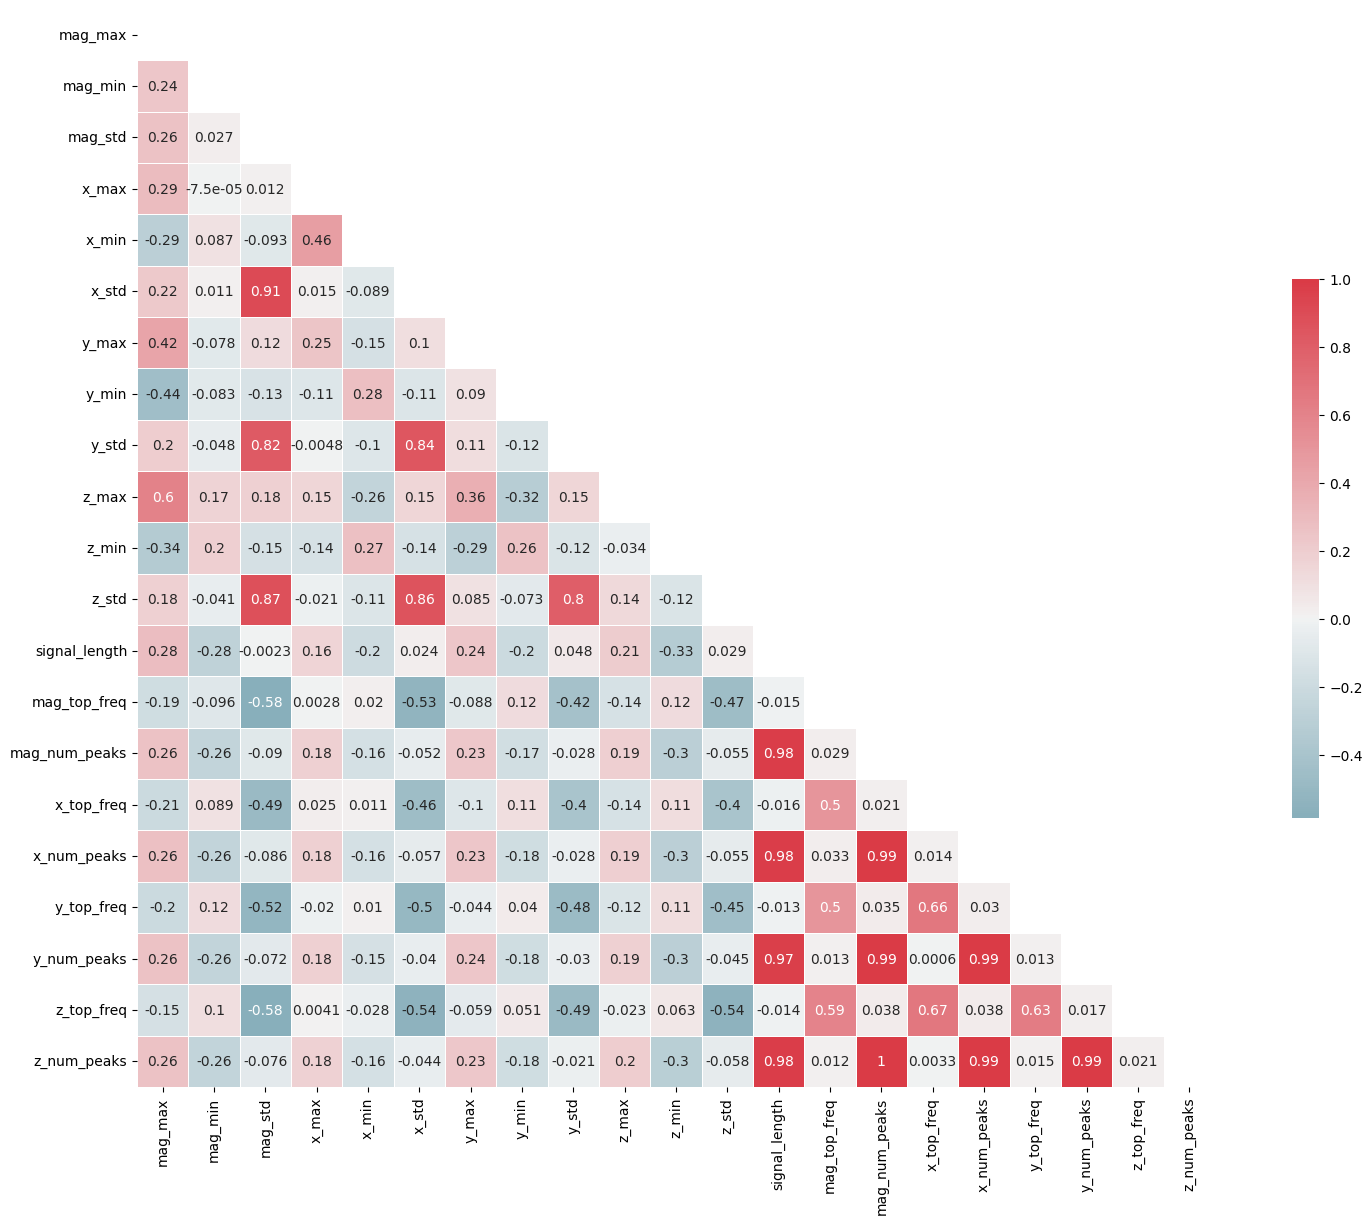

In [98]:
df2 = df.copy()

# Pop a few things off the dataframe, which we don't want to include
# in our correlation analysis
pop = ["trial_num", "gesture", "gesturer", "sampling_rate", "x", "y", "z", "mag"]
for p in pop:
    if p in df2:
        df2.pop(p) 
    
# Compute and show the pairwise correlation table. Again, correlations vary between
# -1 to 1 where values closest to the extremes are more strongly correlated
corr = df2.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 14))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True);

In [99]:
# Drop highly correlated features: 

# Create correlation matrix
# Take the abs value so both negative and positive correlations are mapped from 0 to 1
corr_matrix = df2.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print(to_drop)

['mag_num_peaks', 'x_num_peaks', 'y_num_peaks', 'z_num_peaks']


In [100]:
# Drop features 
df = df.drop(columns=to_drop)

# Pipeline

## Class Cleanup
- There is a major source of error in this project, which is that there are numerous gesture sets by different gesturers, but all under the label `Custom`. When they recorded the gestures, they did not changed the code to give the gesture a custom name, which makes it basically impossible to infer what the gesture actually is without recreating an animation of the points in 3D.
- This means that the `Custom` class is filled with garbage data.
- Let's remove it entirely. 

In [101]:
# Remove Custom
df = df[~df['gesture'].isin(['Custom'])]


# Remove all the unecessary features, store the labels 
to_drop = ["sampling_rate", "x", "y", "z", "mag"]
df = df.drop(columns=to_drop)

user_df = df.copy(deep=True) #we'll use this in # Cross-User Model later in the notebook

trial_indices = df.pop("trial_num") 
gesturer = df.pop('gesturer')
y = df.pop('gesture')
X = df

## Cross Validation
At this point, all of our data is stored in `X` and `y`. We need to partition our data into train-test-(validation) splits. There's several different ways to do this. 

**(Stratified) K-folks Cross Validation** \
In K-Fold Cross-Validation, the dataset is divided into K folds, and the model is trained and evaluated K times.
- Pros:
    - It provides a more robust estimate of the model's performance compared to a single train-test split.
    - It is computationally less expensive than LOOCV for large datasets. 
- Cons:  
    - If K is small, each fold may not represent the full diversity of the dataset.

**Leave One Out Cross Validation** \
In LOOCV, each sample is used as a test set once, and the model is trained on all other samples.
- Pros:
    - It provides a less biased estimate of the model's performance as each sample serves as both training and testing in different iterations.
    - Suitable for small datasets.
- Cons:
    - Computationally expensive, especially for large datasets, as it requires training and evaluating the model for each sample.
 
**(Stratified) Shuffle-Split Cross Validation**\
Shuffle-Split randomly shuffles the dataset and splits it into train and test sets for a specified number of iterations.
- Pros:
    - Provides a compromise between K-Fold and LOOCV by introducing randomness in the selection of training and testing sets.
    - Suitable for large datasets and maintains some of the diversity introduced by LOOCV.
- Cons:
    - The randomness might lead to a less representative subset of the data compared to K-Fold.

It's worth noting that k-folds becomes much better as the value of k increases (typically 5-10). When it comes to deciding between k-folds and shuffle-split, consider this: 
- Stratified K-Fold is more deterministic, ensuring that each sample is used exactly once for testing during one of the K iterations.
- Stratified Shuffle-Split introduces randomness due to shuffling, and a sample may appear in the testing set multiple times or not at all over multiple iterations.

Generally, Shuffle-Split may provide a more robust (but less stable) evaluation. This is particularly useful for large datasets with diverse patterns. You can get a visual understanding of the differences between different cross-validation strategies by looking at [their selection visualizations](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py). 

For our use case, we're going to look at stratified k-folds cross validation. Later, we'll look at strategies like LOOCV and GroupKFolds for developing a cross-user model. 

## Classifiers
Let's use a few classic machine learning algorithms to classify our gesture data. 

1. [k-nearest neighbors (kNN)](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
2. [decision tree](https://scikit-learn.org/stable/modules/tree.html)
3. [random forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

We'll take another look at KNN at the end of this notebook in [Unsupervised Learning](#unsupervised).

**NOTE:** You can skip this next section and load the results from a csv file. Fitting the various models can take a very long time depending on your hardware. 

In [18]:
seed = 42 # used for random state in several places
k    = 10 # number of folds

# Our GridSearchCV is massive, so let's use a cache to checkpoint progress
# in case an error occurs later in the pipeline
cache_directory = 'gridsearch_cache/'
memory = Memory(cache_directory, verbose=0) # pass to GridSearchCV


pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('classifier', SVC()) # Initially SVM but we will gridsearch over other algorithms
    ], 
    memory=memory)

# Define hyperparameter grid for GridSearchCV
# we are going to run extremely robust gridsearch because it's been 7 years since I worked
# closely with this algos and I don't remember heuristics
param_grid = [
    {
    'classifier': [RandomForestClassifier()],  
    'classifier__n_estimators': [50, 100, 200, 300],  # Number of trees in the forest
    'classifier__criterion': ['gini', 'entropy'],  # Function to measure the quality of a split
    'classifier__max_depth': [None, 10, 20, 30],  # Maximum depth of the trees
    'classifier__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'classifier__min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'classifier__max_features': ['sqrt', 'log2', None],  # Number of features to consider for the best split
    # there are even more parameters, but RandomForest is a complex beast and it can get out of hand quickly
    'classifier__n_jobs': [-1], # this should let us paralellize the work on all available processors
    'classifier__random_state': [seed]
    },
    {
    'classifier': [KNeighborsClassifier()], 
    'classifier__n_neighbors': [3, 5, 7, 10],  # Number of neighbors to use
    'classifier__weights': ['uniform', 'distance'],  # Weight function used in prediction
    'classifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algorithm used to compute nearest neighbors
    'classifier__leaf_size': [30, 50, 100],  # Leaf size passed to BallTree or KDTree
    'classifier__p': [1, 2],  # Power parameter for the Minkowski metric
    'classifier__metric': ['euclidean', 'manhattan', 'minkowski'],  # Distance metric
    'classifier__n_jobs': [-1] # this should let us paralellize the work on all available processors
    },
    {
    'classifier': [DecisionTreeClassifier()], 
    'classifier__criterion': ['gini', 'entropy'],  # Function to measure the quality of a split
    'classifier__splitter': ['best', 'random'],  # Strategy to choose the split at each node
    'classifier__max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'classifier__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'classifier__min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'classifier__max_features': ['sqrt', 'log2', None],  # Number of features to consider for the best split
    'classifier__random_state': [seed]
    }
]

# Create and fit GridSearchCV with StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)
grid_search      = GridSearchCV(pipeline, param_grid, cv=stratified_kfold, 
                                scoring='accuracy', n_jobs=-1, verbose=1)

# Create train-test split. We will use the test split for a final evaluation (10% holdout)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=seed)

# Train the models
grid_search.fit(X_train, y_train)
# Save results to disc
results_df = pd.DataFrame(grid_search.cv_results_)
csv_file_path = 'grid_search_results.csv'
results_df.to_csv(csv_file_path, index=False)

Fitting 10 folds for each of 1872 candidates, totalling 18720 fits


/home/master/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


In [19]:
# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Make predictions on the holdout set
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report   = classification_report(y_test, y_pred, zero_division=1)

# Print results
print(f"Best Model:")
pprint(grid_search.best_params_, width=1)
print(f"Overall Accuracy: {accuracy}\n")
print("\n\n")
print("Classification Report:\n", report)

Best Model:
{'classifier': RandomForestClassifier(),
 'classifier__criterion': 'entropy',
 'classifier__max_depth': None,
 'classifier__max_features': 'sqrt',
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 2,
 'classifier__n_estimators': 300,
 'classifier__n_jobs': -1,
 'classifier__random_state': 42}
Overall Accuracy: 0.7746478873239436




Classification Report:
                               precision    recall  f1-score   support

                     At Rest       0.89      0.94      0.91        34
             Backhand Tennis       0.73      0.63      0.68        35
              Baseball Throw       0.83      0.88      0.86        34
                  Bunny Hops       1.00      1.00      1.00         1
             Forehand Tennis       0.74      0.71      0.72        35
                       Heart       0.00      0.00      0.00         1
                        Jump       0.00      0.00      0.00         1
                Jumping Jack       0.00      0.0

/home/master/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/master/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/master/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Exploring the Results
**Note:** If you skipped training the models and want to load results, start here.

In [20]:
# only load from disc if you don't already have a results dataframe
if results_df.empty or results_df is None:
    try:
        results_df = pd.read_csv(csv_file_path)
        print("Results loaded.")
    except FileNotFoundError:
        print("CSV file not found.")
        print("You will need to double-check for the results csv or go back and retrain the models.")

In [21]:
# view what features are in each classifier result
results_df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_classifier', 'param_classifier__criterion',
       'param_classifier__max_depth', 'param_classifier__max_features',
       'param_classifier__min_samples_leaf',
       'param_classifier__min_samples_split', 'param_classifier__n_estimators',
       'param_classifier__n_jobs', 'param_classifier__random_state',
       'param_classifier__algorithm', 'param_classifier__leaf_size',
       'param_classifier__metric', 'param_classifier__n_neighbors',
       'param_classifier__p', 'param_classifier__weights',
       'param_classifier__splitter', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'split5_test_score', 'split6_test_score',
       'split7_test_score', 'split8_test_score', 'split9_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score'],
      dtype='object')

In [22]:
# Sort the results by mean_test_score in descending order
sorted_results = results_df.sort_values(by='mean_test_score', ascending=False)
pd.set_option('display.max_rows', None) # avoid truncated output
pd.set_option('display.max_colwidth', None)

# Display the top results
print("Top Results:")
display(sorted_results[['params', 'mean_test_score', 'std_test_score']].head())

Top Results:


,params,mean_test_score,std_test_score
759,"{'classifier': RandomForestClassifier(), 'classifier__criterion': 'entropy', 'classifier__max_depth': 30, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 300, 'classifier__n_jobs': -1, 'classifier__random_state': 42}",0.751183,0.025732
471,"{'classifier': RandomForestClassifier(), 'classifier__criterion': 'entropy', 'classifier__max_depth': None, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 300, 'classifier__n_jobs': -1, 'classifier__random_state': 42}",0.751183,0.025732
795,"{'classifier': RandomForestClassifier(), 'classifier__criterion': 'entropy', 'classifier__max_depth': 30, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 300, 'classifier__n_jobs': -1, 'classifier__random_state': 42}",0.751183,0.025732
435,"{'classifier': RandomForestClassifier(), 'classifier__criterion': 'entropy', 'classifier__max_depth': None, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 300, 'classifier__n_jobs': -1, 'classifier__random_state': 42}",0.751183,0.025732
651,"{'classifier': RandomForestClassifier(), 'classifier__criterion': 'entropy', 'classifier__max_depth': 20, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 300, 'classifier__n_jobs': -1, 'classifier__random_state': 42}",0.751179,0.026849


In [23]:
# Find the row with the best mean_test_score and get params
best_model_row = results_df.loc[results_df['mean_test_score'].idxmax()]
best_model_params = best_model_row['params']
best_model_params

{'classifier': RandomForestClassifier(),
 'classifier__criterion': 'entropy',
 'classifier__max_depth': None,
 'classifier__max_features': 'sqrt',
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 2,
 'classifier__n_estimators': 300,
 'classifier__n_jobs': -1,
 'classifier__random_state': 42}

In [24]:
if best_model_params['classifier'] == RandomForestClassifier():
    best_model = RandomForestClassifier(**best_model_params)
    
elif best_model_params['classifier'] == KNeighborsClassifier():
    best_model = KNeighborsClassifier(**best_model_params)
    
elif best_model_params['classifier'] == DecisionTreeClassifier():
    best_model = DecisionTreeClassifier(**best_model_params)

# Train the model >> we have to do this because we're loading parameters from disc
best_model.fit(X_train, y_train)

# Make predictions on the holdout set
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, zero_division=1)

print(f"Best Model:")
pprint(grid_search.best_params_, width=1)
print(f"Overall Accuracy: {accuracy}\n")
print("\n\n")
print("Classification Report:\n", report)

Best Model:
{'classifier': RandomForestClassifier(),
 'classifier__criterion': 'entropy',
 'classifier__max_depth': None,
 'classifier__max_features': 'sqrt',
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 2,
 'classifier__n_estimators': 300,
 'classifier__n_jobs': -1,
 'classifier__random_state': 42}
Overall Accuracy: 0.7746478873239436




Classification Report:
                               precision    recall  f1-score   support

                     At Rest       0.89      0.94      0.91        34
             Backhand Tennis       0.73      0.63      0.68        35
              Baseball Throw       0.83      0.88      0.86        34
                  Bunny Hops       1.00      1.00      1.00         1
             Forehand Tennis       0.74      0.71      0.72        35
                       Heart       0.00      0.00      0.00         1
                        Jump       0.00      0.00      0.00         1
                Jumping Jack       0.00      0.0

/home/master/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/master/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/master/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


There are a couple classes that are not represented in the holdout set. Let's see what things look like if we remove them from the classification report:

In [25]:
print(classification_report(y_test,y_pred,labels=np.unique(y_pred)))

                              precision    recall  f1-score   support

                     At Rest       0.89      0.94      0.91        34
             Backhand Tennis       0.73      0.63      0.68        35
              Baseball Throw       0.83      0.88      0.86        34
                  Bunny Hops       1.00      1.00      1.00         1
             Forehand Tennis       0.74      0.71      0.72        35
                  Midair 'S'       0.78      0.82      0.80        34
        Midair Clockwise 'O'       0.62      0.53      0.57        34
Midair Counter-clockwise 'O'       0.62      0.76      0.68        34
            Midair Zorro 'Z'       0.73      0.79      0.76        34
                OverheadWave       1.00      0.86      0.92         7
                       Shake       0.94      0.94      0.94        34
           Underhand Bowling       0.82      0.80      0.81        35

                   micro avg       0.77      0.78      0.78       351
                  

## Confusion matrix for the entire class (holdout only)

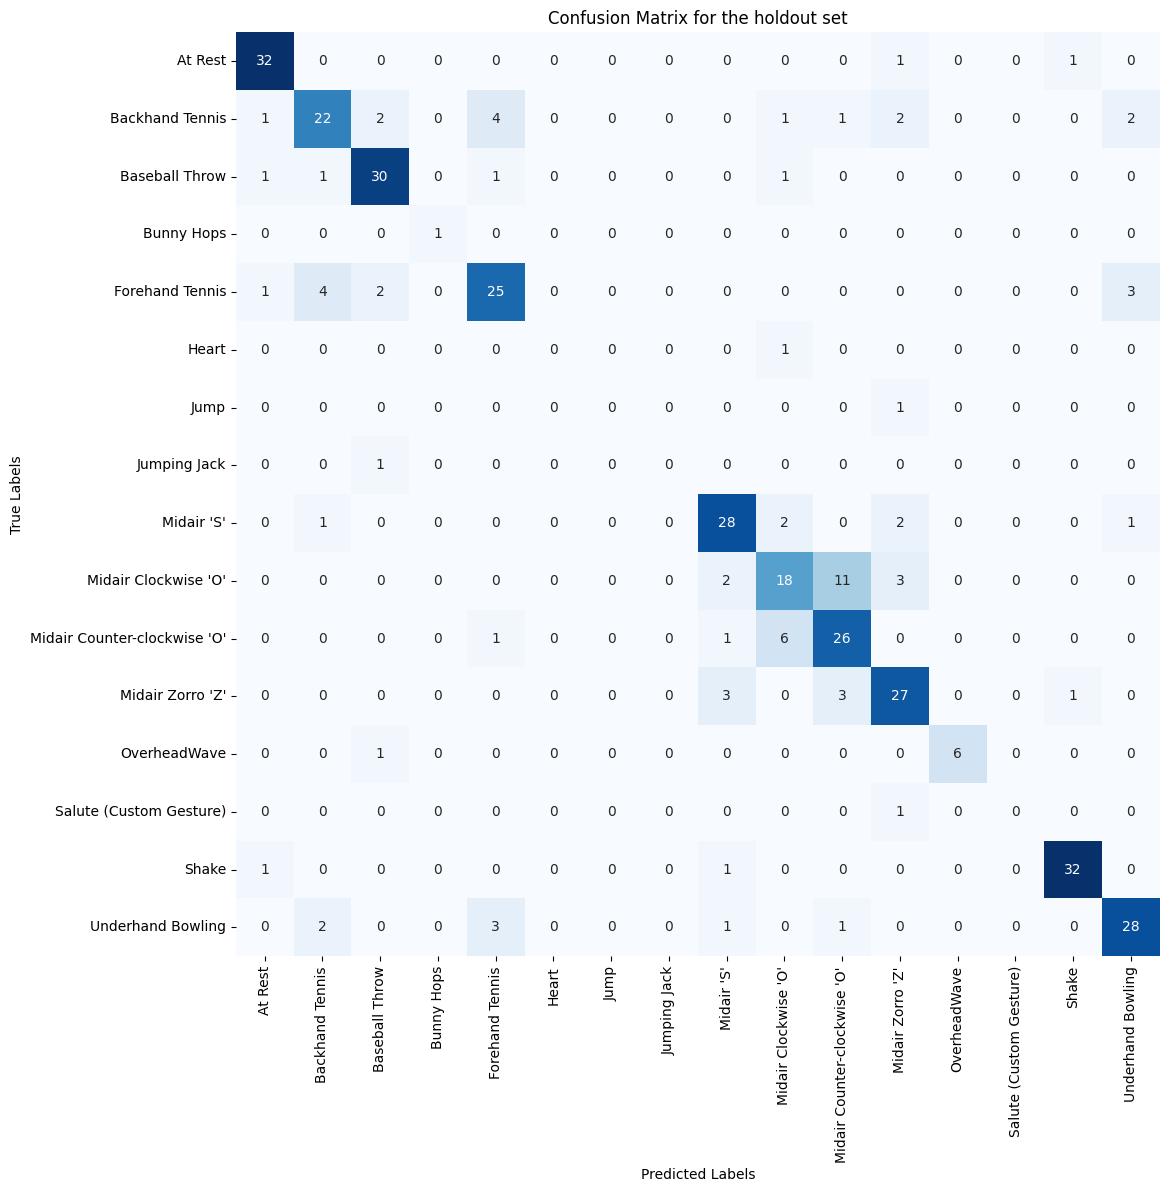

In [26]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(16, 12))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test), square=True)
plt.title(f'Confusion Matrix for the holdout set')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Confusion matrix for your gesture set

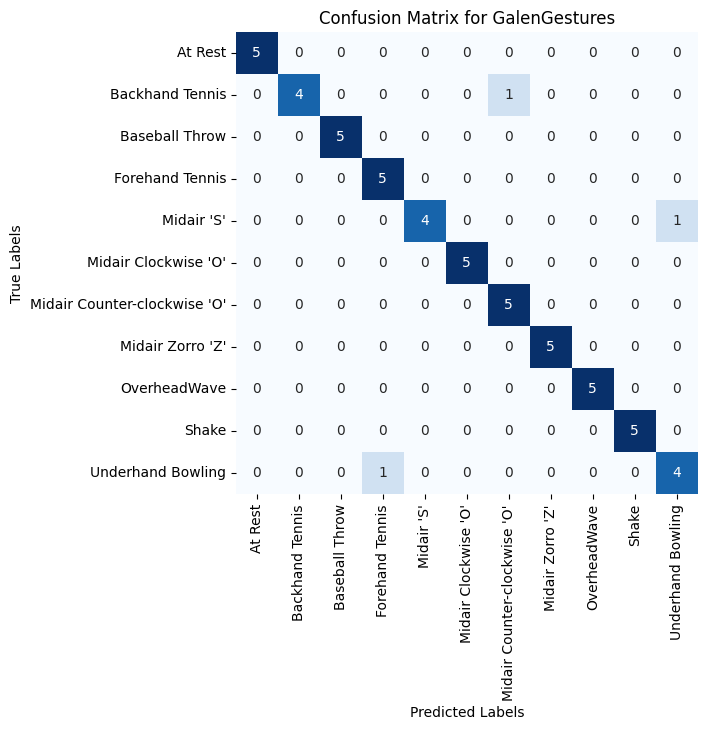

In [27]:
subset_df = user_df[user_df['gesturer'] == "GalenGestures"]
trial_indices = subset_df.pop("trial_num") 
gesturer = subset_df.pop('gesturer')
y = subset_df.pop('gesture')
X = subset_df

# predict on all the trials for that user
y_pred = best_model.predict(X)
cm = confusion_matrix(y, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=np.unique(y_pred), yticklabels=np.unique(y_pred), square=True)
plt.title(f'Confusion Matrix for GalenGestures')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Confusion matrix for Jon's gesture set

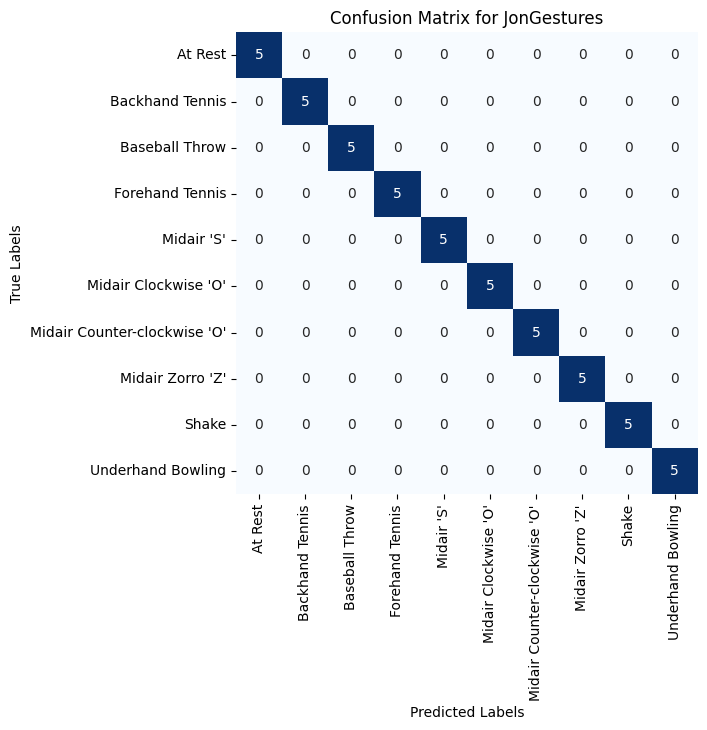

In [28]:
subset_df = user_df[user_df['gesturer'] == "JonGestures"]
trial_indices = subset_df.pop("trial_num") 
gesturer = subset_df.pop('gesturer')
y = subset_df.pop('gesture')
X = subset_df

y_pred = best_model.predict(X)
cm = confusion_matrix(y, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=np.unique(y), yticklabels=np.unique(y), square=True)
plt.title(f'Confusion Matrix for JonGestures')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Confusion Matrix for all gesture sets except for GalenSlow, GalenFast, GalenMedium

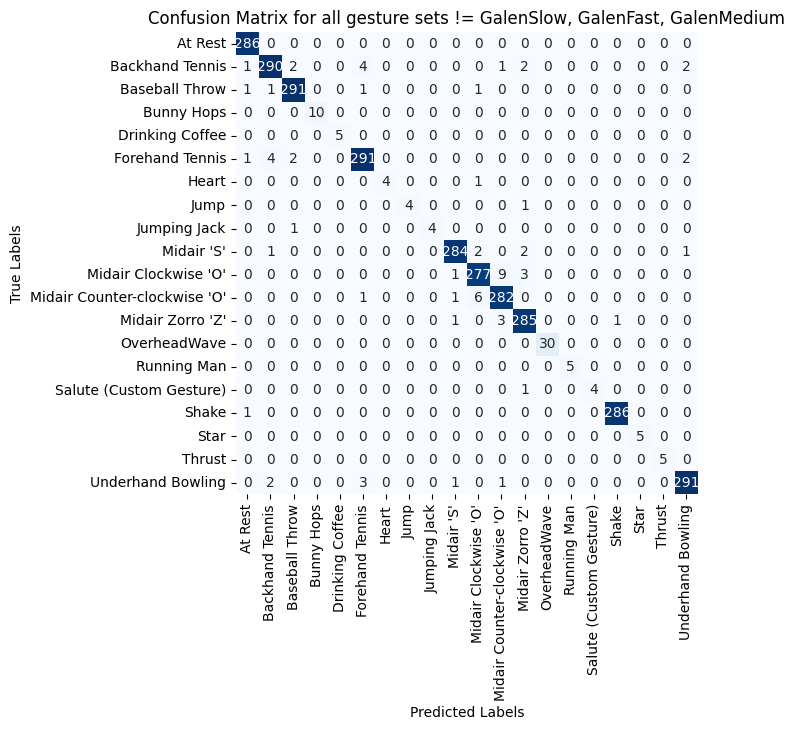

In [29]:
excluded_values = ['GalenSlowGestures', 'GalenMediumGestures', 'GalenMediumGestures']
subset_df = user_df[~user_df['gesturer'].isin(excluded_values)]

trial_indices = subset_df.pop("trial_num") 
gesturer = subset_df.pop('gesturer')
y = subset_df.pop('gesture')
X = subset_df

y_pred = best_model.predict(X)
cm = confusion_matrix(y, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=np.unique(y_pred), yticklabels=np.unique(y_pred), square=True)
plt.title(f'Confusion Matrix for all gesture sets != GalenSlow, GalenFast, GalenMedium')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Cross-User Models

## Cross-User #1
The first model is trained on all users (the training set) except for one (the test set). Iterate through all users as test sets and report classification accuracies for each (in graph form) as well as overall accuracies (average accuracy across all users with standard deviation). To be clear, you are not running a standard k-fold cross validation here but instead a leave-one-out validation approach (where you leave one user out from the training set per classification experiment).

For the next 2 models we'll just use RandomForest. 

In [30]:
seed = 42 # used for random state in several places

pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('classifier', RandomForestClassifier()) 
    ])

# Define hyperparameter grid for GridSearchCV
param_grid = [
    {
    'classifier': [RandomForestClassifier()],  
    'classifier__n_estimators': [300],  # Number of trees in the forest
    'classifier__criterion': ['gini', 'entropy'],  # Function to measure the quality of a split
    'classifier__max_depth': [None, 10, 20, 30],  # Maximum depth of the trees
    'classifier__min_samples_split': [2],  # Minimum number of samples required to split an internal node
    'classifier__min_samples_leaf': [1],  # Minimum number of samples required to be at a leaf node
    'classifier__max_features': ['sqrt', 'log2', None],  # Number of features to consider for the best split
    # there are even more parameters, but RandomForest is a complex beast and it can get out of hand quickly
    'classifier__n_jobs': [-1], # this should let us paralellize the work on all available processors
    'classifier__random_state': [seed]
    }
]

trial_nums = user_df.pop('trial_num')
y = user_df.pop('gesture')
X = user_df

# Not sure why, but string labels cause a problem for me in LeaveOneGroupOut
label_encoder = LabelEncoder()
X['gesturer'] = label_encoder.fit_transform(X['gesturer'])

# Create train-test split. We will use the test split for a final evaluation (10% holdout)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=seed)

# Create and fit GridSearchCV with LeaveOneGroupOut
logo = LeaveOneGroupOut()
grid_search = GridSearchCV(pipeline, param_grid, cv=logo.split(X_train, y_train, groups=X_train['gesturer']),
                           scoring='accuracy', n_jobs=-1, verbose=1, error_score='raise')

# Train the models
grid_search.fit(X_train, y_train)

# Save results to disc
results_df = pd.DataFrame(grid_search.cv_results_)
csv_file_path = 'logo_results.csv'
results_df.to_csv(csv_file_path, index=False)

Fitting 56 folds for each of 24 candidates, totalling 1344 fits


**NOTE:** I have not included the logic for creating a dataframe and predictor by loading the results from the `.csv`. Please see the `Exploring the Results` section for an example if you need to load from disk.

Classification Report:
                               precision    recall  f1-score   support

                     At Rest       0.92      0.97      0.94        34
             Backhand Tennis       0.79      0.74      0.76        35
              Baseball Throw       0.88      0.88      0.88        34
                  Bunny Hops       1.00      1.00      1.00         1
             Forehand Tennis       0.76      0.71      0.74        35
                       Heart       1.00      0.00      0.00         1
                        Jump       1.00      0.00      0.00         1
                Jumping Jack       1.00      0.00      0.00         1
                  Midair 'S'       0.78      0.82      0.80        34
        Midair Clockwise 'O'       0.61      0.59      0.60        34
Midair Counter-clockwise 'O'       0.63      0.76      0.69        34
            Midair Zorro 'Z'       0.75      0.79      0.77        34
                OverheadWave       1.00      0.86      0.92      

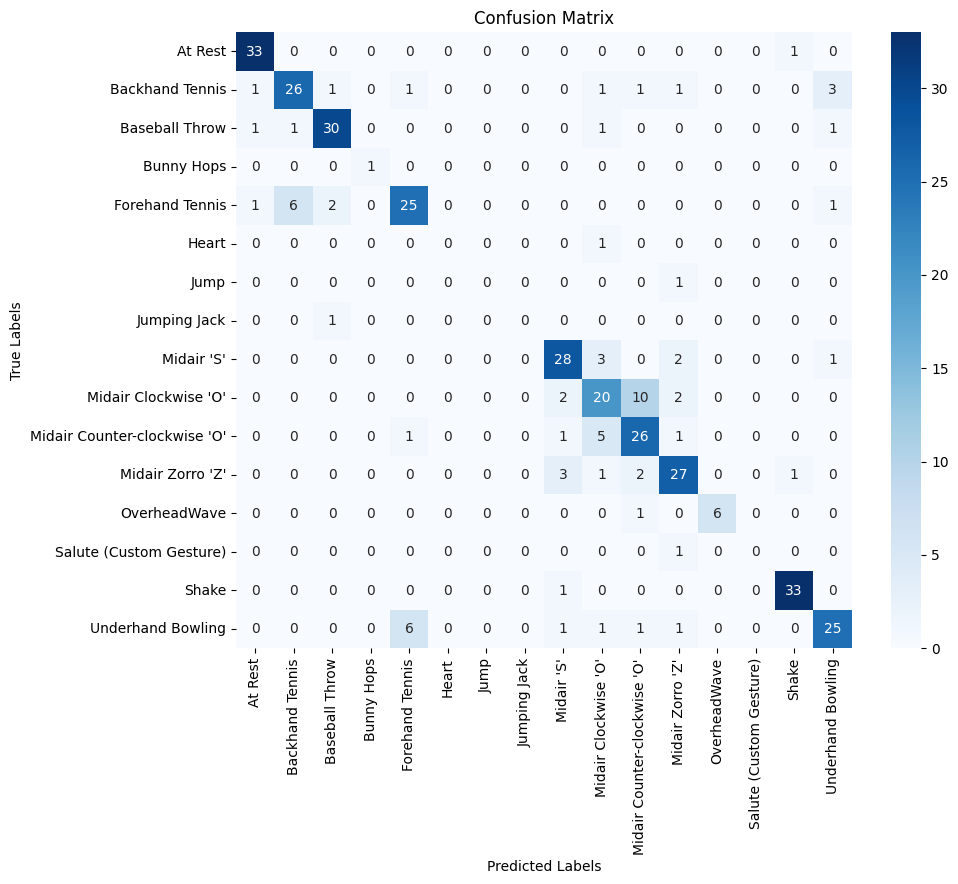

In [41]:
best_estimator = grid_search.best_estimator_
y_pred = best_estimator.predict(X_test)

cr = classification_report(y_test, y_pred, zero_division=1)
print("Classification Report:\n", cr)

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test), square=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

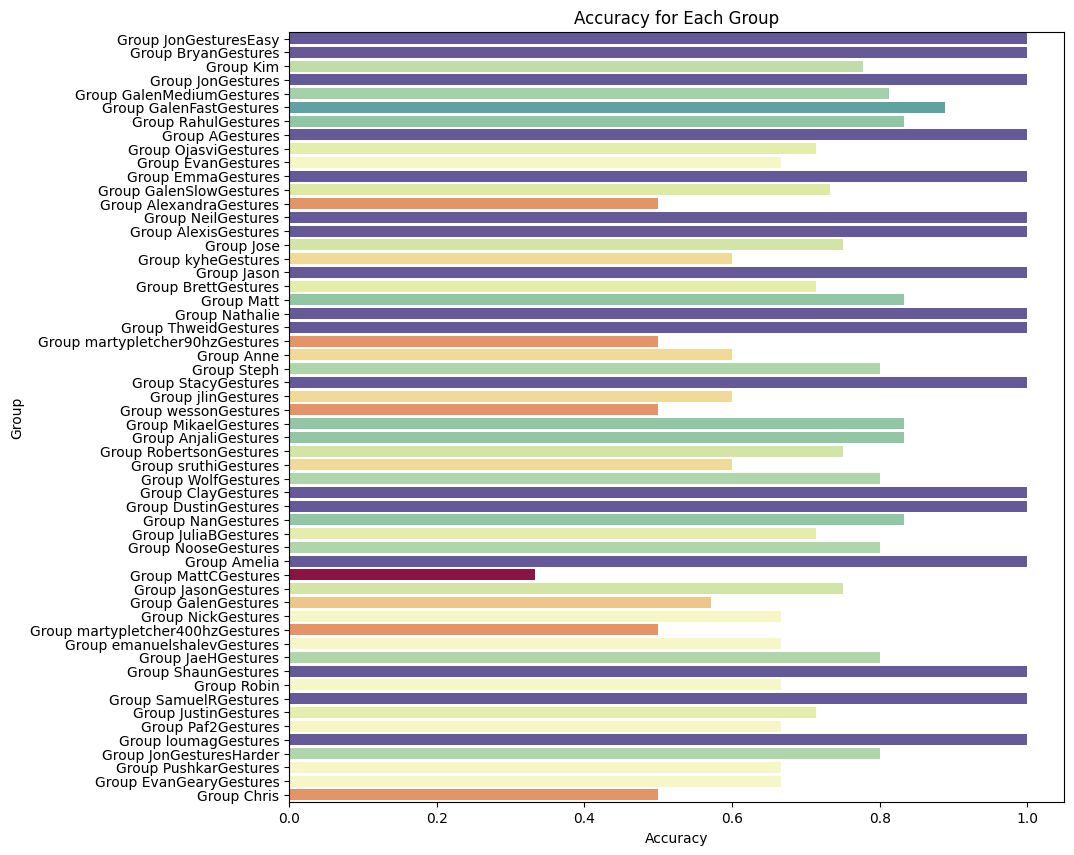

In [71]:
# Initialize lists to store group names and corresponding accuracies
group_names = []
accuracies = []

for group in X_test['gesturer'].unique():
    group_mask = X_test['gesturer'] == group
    group_predictions = y_pred[group_mask]
    group_true_labels = y_test[group_mask]

    accuracy = accuracy_score(group_true_labels, group_predictions)
    decoded_label = label_encoder.inverse_transform([group])
    group_names.append(f'Group {decoded_label[0]}')
    accuracies.append(accuracy)

plt.figure(figsize=(10, 10))
sns.barplot(x=accuracies, y=group_names, hue=accuracies, palette="Spectral", orient="h",  legend=False)
plt.xlabel('Accuracy')
plt.ylabel('Group')
plt.title('Accuracy for Each Group')
plt.show()

## Cross-User #2

For the second cross-user model, train again on all users but also four of the five gesture samples (of each gesture) from the target user. To simplify things, you need not run k-fold cross validation. You can simply randomly select four of five gesture samples (once). We expect that classification accuracies should increase here as your training set will include data from the actual target user. Is that what happens? Why or why not? Ideas for how to solve this?

In [104]:
user_df2 = user_df.copy(deep=True)

# Select the test gesture set --> "GalenGestures"
just_test_gesturer = user_df2.loc[user_df2['gesturer'] == "GalenGestures"]
test_df = pd.DataFrame()
drop_indices = []

# Extract 1 random gesture trial for each gesture class in the test gesture set
# The test DataFrame will be test_df
print("The randomly selected test trials:")
for gesture_name in user_df2.loc[user_df2['gesturer'] == "GalenGestures", 'gesture'].unique():
    just_gesture = just_test_gesturer.loc[user_df2['gesture'] == gesture_name]
    random_gesture_trial = just_gesture.sample(1, random_state=42) # change random state to an int to control random seed
    selected_trial_num = random_gesture_trial['trial_num'].iloc[0]
    print(f"  '{gesture_name}' Selected trial num: {selected_trial_num} at DataFrame index {random_gesture_trial.index[0]}")
    drop_indices.append(random_gesture_trial.index[0])
    test_df = test_df._append(random_gesture_trial)
    # test_df = pd.concat([test_df, pd.DataFrame([random_gesture_trial])], ignore_index=True)

# We don't want trial number or gesturer as an input feature, so remove them
trial_indices = user_df2.pop("trial_num")
gesturer = user_df2.pop('gesturer')
test_df.pop('gesturer')
test_df.pop('trial_num')
    
# Setup training and test DataFrames
training_df = user_df2.drop(drop_indices)
X_train = training_df
y_train = training_df.pop('gesture')
X_test = test_df
y_test = test_df.pop('gesture')

# Scale data first
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

The randomly selected test trials:
  'At Rest' Selected trial num: 1 at DataFrame index 1577
  'Backhand Tennis' Selected trial num: 1 at DataFrame index 1582
  'Baseball Throw' Selected trial num: 1 at DataFrame index 1587
  'Forehand Tennis' Selected trial num: 1 at DataFrame index 1592
  'Midair 'S'' Selected trial num: 1 at DataFrame index 1597
  'Midair Clockwise 'O'' Selected trial num: 1 at DataFrame index 1602
  'Midair Counter-clockwise 'O'' Selected trial num: 1 at DataFrame index 1607
  'Midair Zorro 'Z'' Selected trial num: 1 at DataFrame index 1612
  'OverheadWave' Selected trial num: 1 at DataFrame index 1617
  'Shake' Selected trial num: 1 at DataFrame index 1622
  'Underhand Bowling' Selected trial num: 1 at DataFrame index 1627


In [105]:
# Get information for best model after GridSearch so we can use it
best_params = best_estimator.get_params()
print("Best Estimator Parameters:")
print(best_params)

Best Estimator Parameters:
{'memory': None, 'steps': [('scaler', StandardScaler()), ('classifier', RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=300,
                       n_jobs=-1, random_state=42))], 'verbose': False, 'scaler': StandardScaler(), 'classifier': RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=300,
                       n_jobs=-1, random_state=42), 'scaler__copy': True, 'scaler__with_mean': True, 'scaler__with_std': True, 'classifier__bootstrap': True, 'classifier__ccp_alpha': 0.0, 'classifier__class_weight': None, 'classifier__criterion': 'entropy', 'classifier__max_depth': 20, 'classifier__max_features': 'sqrt', 'classifier__max_leaf_nodes': None, 'classifier__max_samples': None, 'classifier__min_impurity_decrease': 0.0, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__min_weight_fraction_leaf': 0.0, 'classifier__monotonic_cst': None, 'classifier__n_estimators': 300, 'classifier__n_jo

In [107]:
best_estimator_params = {
    'criterion': 'entropy',
    'max_depth': 20,
    'n_estimators': 300,
    'n_jobs': -1,
    'random_state': 42
}

rfc = RandomForestClassifier(**best_estimator_params)
rfc.fit(X_train, y_train)

score = rfc.score(X_test, y_test)
print("----")
print(f"Classification accuracy: {score * 100:.2f}%")

----
Classification accuracy: 72.73%


In [ ]:
# Create train-test split. We will use the test split for a final evaluation (10% holdout)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=seed)

# [Unsupervised Learning](#unsupervised)

Imagine that instead of trying to classify the gestures, you were trying to determine how many unique gestures there were in a set (for this scenario, pretend that you do not actually know). Design and implement an approach that attempts to determine how many unique gestures there are in the set.

We will take a look at 2 methods related to K Nearest Neighbors: [the elbow method]() and [silhouette analysis](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html). These techniques used to determine the optimal number of clusters in a dataset when performing clustering algorithms. Both methods aim to find a balance between the number of clusters and the cohesion/separation of the data points within and between clusters.

### Elbow Method:

1. **How it Works:**
   - The elbow method looks at the within-cluster sum of squares (inertia) as a function of the number of clusters.
   - As the number of clusters increases, the inertia typically decreases, because more clusters mean smaller and more compact clusters.
   - However, there is a point where adding more clusters does not significantly reduce inertia, and the rate of decrease sharply changes.
   - The "elbow" in the plot indicates the point where the rate of decrease slows down, suggesting an optimal number of clusters.

2. **Steps:**
   - Apply the clustering algorithm for different numbers of clusters and calculate the inertia for each.
   - Plot the number of clusters against the inertia.
   - Look for the point where the inertia begins to decrease at a slower rate, resembling an elbow.

### Silhouette Analysis:

1. **How it Works:**
   - Silhouette analysis measures how similar an object is to its own cluster (cohesion) compared to other clusters (separation).
   - The silhouette score ranges from -1 to 1. A high silhouette score indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.
   - Silhouette scores near 0 indicate overlapping clusters, while negative scores suggest that data points might have been assigned to the wrong cluster.

2. **Steps:**
   - For each data point, calculate its silhouette score.
   - The average silhouette score over all data points is used as a measure of the overall quality of the clustering.
   - Silhouette scores range from -1 to 1, where a higher score indicates better-defined clusters.

In both methods, the goal is to identify a point where adding more clusters does not significantly improve the quality of the clustering, helping you determine the optimal number of clusters for your data. Choose the number of clusters that provides a good trade-off between cohesion within clusters and separation between clusters.

In [ ]:
true_num_clusters = len(y.unique()) # Get the number of unique gestures
print(f"Actual number of unique gesture classes: {true_num_clusters}\n")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) # Use the entire dataset because we're not training

# Apply K-Means with varying numbers of clusters
cluster_range = range(2, 25)
inertia_values = []
silhouette_scores = []

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=seed)
    kmeans.fit(X_scaled)
    inertia_values.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.predict(X_scaled)))


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(cluster_range, inertia_values, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')

plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Analysis')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

These results are dissapointing, but perhaps not surprising. The best performing KNN classifier had an average accuracy of 0.715405, which is lower than every single RandomForest perumutation. Given the current set of features, it makes sense that clustering data would be very messy since we're approximately working with the signature of moving around within the same 3D point cloud. This is also telling given the high distinction at 2 clusters because of `At Rest` and everything else.

See [Next Steps](#next-steps) for additional ideas on features that would generate a more robust signal. 

# [Next Steps](#next-steps)

Below are some additional experiements I would like to add to this notebook.

## Feature Engineering
- Add peak to peak amplitude (replace min/max) 
- Add DTW distance
    - This would require sampling or creating a "golden" template for each gesture that would be used to calculate the DTW distance from that template for each trial.
    - Further, you could "one-hot encode" (not really) the distance for a trial for each gesture class. So we would add N features where N = number of gesture classes.
    - This would be very compute intensive on the pre-processing side, but could give a very strong signal and help with edge cases or where the number of trials are very low (custom gestures).  

## Data Augmentation
- Data augmentation / adding noise / upsampling custom gestures 
- Goal for experiment would be to boost performance on all the custom gestures

## FIGLAB Replication
- Last experiment would be replicating [FIGLABS VGG16](https://github.com/FIGLAB/hand-activities/tree/master) approach from [Sensing Fine-Grained Hand Activity with Smartwatches](https://dl.acm.org/doi/10.1145/3290605.3300568) by Laput and Harrison.
- This approach would be interesting because it would most likely require _de-engineering_ features and going back to raw accelerometer sensor data.
- The 3d convolutions of the model architecture lend itself to learning cross-axis relationships, so the spatio-temporal signal should be able to be extracted without additional feature engineering.

## GridSearchCV Visualizations
- Add more exploration of hyperparameter search space, including [visualizations](http://www.clungu.com/Visualising-grid-search-results/).